<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Treball Final de Màster</p>
<p style="margin: 0; text-align:right;">Màster universitari en Ciència de dades (Data science) · 2022</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Antoni Vanrell Valls</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Model predictiu de l’adenocarcinoma ductal de pàncrees

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler

Lectura del dataset GEO ("GSE28735")
------------------

In [3]:
!pip install GEOparse
import GEOparse
import pylab as pl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 278 kB 5.1 MB/s 
  Created wheel for GEOparse: filename=GEOparse-2.0.3-py3-none-any.whl size=29065 sha256=7bf30fc9729a8d1239190b449ccff0e8f1ace1c17411513640fb55468a4845d2
  Stored in directory: /root/.cache/pip/wheels/4d/15/e8/fbf3b47444215d9728c20d7b35436b50086aa67c2ad6dcedad
Successfully built GEOparse


In [4]:
gse = GEOparse.get_GEO("GSE28735")

# Refrència: https://readthedocs.org/projects/geoparse/downloads/pdf/latest/

28-May-2022 08:50:25 DEBUG utils - Directory ./ already exists. Skipping.
28-May-2022 08:50:25 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE28nnn/GSE28735/soft/GSE28735_family.soft.gz to ./GSE28735_family.soft.gz
100%|██████████| 27.7M/27.7M [00:00<00:00, 37.1MB/s]
28-May-2022 08:50:26 DEBUG downloader - Size validation passed
28-May-2022 08:50:26 DEBUG downloader - Moving /tmp/tmpqd_xbgcz to /content/GSE28735_family.soft.gz
28-May-2022 08:50:26 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE28nnn/GSE28735/soft/GSE28735_family.soft.gz
28-May-2022 08:50:26 INFO GEOparse - Parsing ./GSE28735_family.soft.gz: 
28-May-2022 08:50:26 DEBUG GEOparse - DATABASE: GeoMiame
28-May-2022 08:50:26 DEBUG GEOparse - SERIES: GSE28735
28-May-2022 08:50:26 DEBUG GEOparse - PLATFORM: GPL6244
28-May-2022 08:50:29 DEBUG GEOparse - SAMPLE: GSM711904
28-May-2022 08:50:29 DEBUG GEOparse - SAMPLE: GSM711905
28-May-2022 08:50:29 DEBUG GEOparse - SAMPLE:

Info pacients
--------------

In [ ]:
# Conjunt de dades amb informació dels 45 pacients (2 files per pacient)
data_info = gse.phenotype_data[['title', 'characteristics_ch1.0.tissue',	'characteristics_ch1.1.survival_month',	'characteristics_ch1.2.cancer_death']].reset_index()
data_info = pd.DataFrame(data_info, index = None)
data_info.columns=['mostra','titol', 'teixit', 'mesos_supervivencia', 'mort']
data_info

,mostra,titol,teixit,mesos_supervivencia,mort
0,GSM711904,"human pancreatic tumor tissue, patient sample 1",T,51,1
1,GSM711905,"human pancreatic nontumor tissue, patient samp...",N,51,1
2,GSM711906,"human pancreatic tumor tissue, patient sample 2",T,7,1
3,GSM711907,"human pancreatic nontumor tissue, patient samp...",N,7,1
4,GSM711908,"human pancreatic tumor tissue, patient sample 3",T,3,1
...,...,...,...,...,...
85,GSM711989,"human pancreatic nontumor tissue, patient samp...",N,15,1
86,GSM711990,"human pancreatic tumor tissue, patient sample 40",T,5,1
87,GSM711991,"human pancreatic nontumor tissue, patient samp...",N,5,1
88,GSM711992,"human pancreatic tumor tissue, patient sample 41",T,13,1


Microarrays
-----


In [8]:
sample = gse.pivot_samples('VALUE')
sample.head()

name,GSM711904,GSM711905,GSM711906,GSM711907,GSM711908,GSM711909,GSM711910,GSM711911,GSM711912,GSM711913,...,GSM711984,GSM711985,GSM711986,GSM711987,GSM711988,GSM711989,GSM711990,GSM711991,GSM711992,GSM711993
ID_REF,,,,,,,,,,,,,,,,,,,,,
7896736,3.30105,4.31783,2.98749,3.54810,2.97383,3.51183,3.73380,3.05580,3.65471,3.43433,...,3.39440,2.87855,3.80862,3.37371,3.23260,3.70617,3.60045,2.86291,3.05884,2.92631
7896738,1.85066,1.84630,2.14159,1.83839,2.37636,1.80252,1.87960,2.17260,1.80345,1.82737,...,1.96892,1.75337,1.84398,1.98738,1.84953,1.84010,1.80850,2.13157,1.95045,1.92559
7896740,2.02519,2.11336,2.15384,1.88753,2.22671,1.88364,1.87758,2.12081,2.00478,1.95566,...,2.19635,1.90283,1.89918,1.89874,2.30777,1.96060,1.78306,1.89889,2.00879,2.01001
7896742,4.47212,5.26114,4.45806,5.72147,5.18768,4.73796,5.15177,5.59669,4.71598,5.15677,...,5.91834,5.75434,5.18510,5.69252,4.89530,5.22140,4.34985,4.94630,4.99349,5.58175
7896744,4.33654,4.48297,4.44503,4.62130,4.09481,4.18046,4.97488,5.08431,4.60058,4.64041,...,5.08048,4.98365,3.59296,4.79659,4.75569,4.41755,2.64899,3.66951,4.82973,5.41124


In [ ]:
sample_transpose = np.transpose(sample)
sample_transpose

ID_REF,7896736,7896738,7896740,7896742,7896744,7896746,7896748,7896750,7896752,7896754,...,8180078,8180086,8180093,8180100,8180105,8180111,8180123,8180144,8180166,8180179
name,,,,,,,,,,,,,,,,,,,,,
GSM711904,3.30105,1.85066,2.02519,4.47212,4.33654,7.11794,8.14456,2.45761,6.78099,5.69052,...,6.47743,5.70131,4.05683,9.23486,4.17363,5.63089,6.11840,5.15386,6.62677,3.93942
GSM711905,4.31783,1.84630,2.11336,5.26114,4.48297,8.42338,8.73852,3.54018,7.24570,6.11363,...,5.05133,4.75168,4.53917,6.72498,4.21738,5.24242,5.74307,4.62371,5.64747,3.71708
GSM711906,2.98749,2.14159,2.15384,4.45806,4.44503,6.24828,7.04447,2.02138,5.94896,6.49958,...,6.11866,5.42709,3.42402,8.58928,3.99353,5.42773,5.93449,5.22868,7.36476,4.24016
GSM711907,3.54810,1.83839,1.88753,5.72147,4.62130,6.79179,7.03643,2.38217,5.88869,5.04972,...,7.11621,6.19605,4.32890,9.56960,3.64442,5.71823,5.96098,5.27068,7.06237,3.59254
GSM711908,2.97383,2.37636,2.22671,5.18768,4.09481,6.96976,7.28209,1.83525,6.02336,4.95410,...,5.53045,4.24261,3.61616,6.47930,3.51167,5.95088,6.19834,6.00472,6.76463,4.18457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM711989,3.70617,1.84010,1.96060,5.22140,4.41755,6.33372,5.95656,3.10828,4.87210,5.18518,...,6.65486,6.08787,3.95905,9.46344,4.14619,5.58084,5.91789,5.20453,6.51660,3.58034
GSM711990,3.60045,1.80850,1.78306,4.34985,2.64899,5.97438,5.79948,1.82114,4.41738,4.80324,...,7.48372,6.88411,4.15050,10.47690,3.42617,5.79621,6.12817,5.63189,6.87368,3.82281
GSM711991,2.86291,2.13157,1.89889,4.94630,3.66951,7.83129,8.55361,2.78931,6.89964,4.84189,...,6.88995,6.53724,3.86977,9.97945,3.60522,5.62693,5.88050,5.36413,6.59147,3.83400


In [ ]:
# Triam les columnes dels 5 gens més expressats diferents trobats en el treball
sample_with_gens_diff = sample_transpose[[7908072, 7924029, 8037408, 7901175, 8049487]]
sample_with_gens_diff = sample_with_gens_diff.reset_index()
sample_with_gens_diff.head(5)

ID_REF,name,7908072,7924029,8037408,7901175,8049487
0,GSM711904,8.18692,6.88415,4.80784,8.19844,6.88355
1,GSM711905,3.49501,3.86524,3.88595,4.00368,4.34381
2,GSM711906,10.46150,9.31546,5.97915,8.63607,6.84127
3,GSM711907,4.93370,4.11993,3.87221,4.44401,4.46318
4,GSM711908,9.33552,8.35997,5.66242,8.96720,6.44561


7908072	<- LAMC2

7924029	<- LAMB3

8037408	<- KCNN4

7901175	<- TSPAN1

8049487	<- MLPH

In [ ]:
df = pd.DataFrame(sample_with_gens_diff, index = None)
df.columns=['mostra','LAMC2', 'LAMB3', 'KCNN4', 'TSPAN1', 'MLPH']
df

,mostra,LAMC2,LAMB3,KCNN4,TSPAN1,MLPH
0,GSM711904,8.18692,6.88415,4.80784,8.19844,6.88355
1,GSM711905,3.49501,3.86524,3.88595,4.00368,4.34381
2,GSM711906,10.46150,9.31546,5.97915,8.63607,6.84127
3,GSM711907,4.93370,4.11993,3.87221,4.44401,4.46318
4,GSM711908,9.33552,8.35997,5.66242,8.96720,6.44561
...,...,...,...,...,...,...
85,GSM711989,5.08301,4.30221,3.79387,5.47445,4.70872
86,GSM711990,7.16598,5.58715,4.31418,6.63540,5.13850
87,GSM711991,5.04872,4.10117,3.40290,3.98509,4.34258
88,GSM711992,7.92758,6.98113,4.62575,6.68129,5.80828


Unim data_info i df
----------------------------

In [ ]:
dataset_info = pd.merge(df, data_info, left_on='mostra', right_on='mostra')
dataset_info

,mostra,LAMC2,LAMB3,KCNN4,TSPAN1,MLPH,titol,teixit,mesos_supervivencia,mort
0,GSM711904,8.18692,6.88415,4.80784,8.19844,6.88355,"human pancreatic tumor tissue, patient sample 1",T,51,1
1,GSM711905,3.49501,3.86524,3.88595,4.00368,4.34381,"human pancreatic nontumor tissue, patient samp...",N,51,1
2,GSM711906,10.46150,9.31546,5.97915,8.63607,6.84127,"human pancreatic tumor tissue, patient sample 2",T,7,1
3,GSM711907,4.93370,4.11993,3.87221,4.44401,4.46318,"human pancreatic nontumor tissue, patient samp...",N,7,1
4,GSM711908,9.33552,8.35997,5.66242,8.96720,6.44561,"human pancreatic tumor tissue, patient sample 3",T,3,1
...,...,...,...,...,...,...,...,...,...,...
85,GSM711989,5.08301,4.30221,3.79387,5.47445,4.70872,"human pancreatic nontumor tissue, patient samp...",N,15,1
86,GSM711990,7.16598,5.58715,4.31418,6.63540,5.13850,"human pancreatic tumor tissue, patient sample 40",T,5,1
87,GSM711991,5.04872,4.10117,3.40290,3.98509,4.34258,"human pancreatic nontumor tissue, patient samp...",N,5,1
88,GSM711992,7.92758,6.98113,4.62575,6.68129,5.80828,"human pancreatic tumor tissue, patient sample 41",T,13,1


In [ ]:
# Ens quedam amb les columnes que usarem pels model
dataset = dataset_info[['mostra','LAMC2', 'LAMB3', 'KCNN4', 'TSPAN1', 'MLPH', 'teixit']]
dataset2 = dataset_info[['LAMC2', 'LAMB3', 'KCNN4', 'TSPAN1', 'MLPH', 'teixit']]
dataset.head(5)

,mostra,LAMC2,LAMB3,KCNN4,TSPAN1,MLPH,teixit
0,GSM711904,8.18692,6.88415,4.80784,8.19844,6.88355,T
1,GSM711905,3.49501,3.86524,3.88595,4.00368,4.34381,N
2,GSM711906,10.46150,9.31546,5.97915,8.63607,6.84127,T
3,GSM711907,4.93370,4.11993,3.87221,4.44401,4.46318,N
4,GSM711908,9.33552,8.35997,5.66242,8.96720,6.44561,T


In [ ]:
# Verifiquem que no hi ha nulls
dataset.isnull().sum()

mostra    0
LAMC2     0
LAMB3     0
KCNN4     0
TSPAN1    0
MLPH      0
teixit    0
dtype: int64

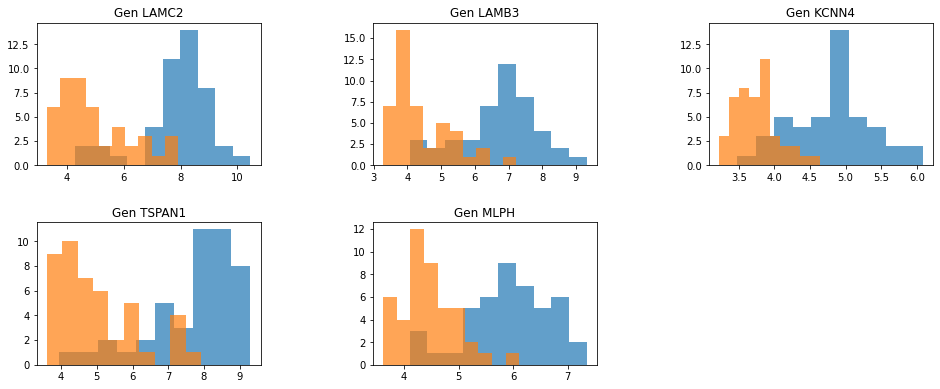

In [ ]:
# Distributions de les expressions del gens (histogrames)

plt.subplot(3, 3, 1)
plt.title('Gen LAMC2')
plt.hist(dataset.loc[dataset['teixit'] == 'T','LAMC2'], alpha = 0.7)
plt.hist(dataset.loc[dataset['teixit'] == 'N','LAMC2'], alpha = 0.7)

plt.subplot(3, 3, 2)
plt.title('Gen LAMB3')
plt.hist(dataset.loc[dataset['teixit'] == 'T','LAMB3'], alpha = 0.7)
plt.hist(dataset.loc[dataset['teixit'] == 'N','LAMB3'], alpha = 0.7)

plt.subplot(3, 3, 3)
plt.title('Gen KCNN4')
plt.hist(dataset.loc[dataset['teixit'] == 'T','KCNN4'], alpha = 0.7)
plt.hist(dataset.loc[dataset['teixit'] == 'N','KCNN4'], alpha = 0.7)

plt.subplot(3, 3, 4)
plt.title('Gen TSPAN1')
plt.hist(dataset.loc[dataset['teixit'] == 'T','TSPAN1'], alpha = 0.7)
plt.hist(dataset.loc[dataset['teixit'] == 'N','TSPAN1'], alpha = 0.7)

plt.subplot(3, 3, 5)
plt.title('Gen MLPH')
plt.hist(dataset.loc[dataset['teixit'] == 'T','MLPH'], alpha = 0.7)
plt.hist(dataset.loc[dataset['teixit'] == 'N','MLPH'], alpha = 0.7)

plt.subplots_adjust(wspace=0.5, bottom=-1, right=2.2, hspace=0.4)
plt.show() 

Test-train split
--------------

In [ ]:
condicions = [(dataset['teixit'] == 'T') , (dataset['teixit'] == 'N')]
triar = ['1', '0']

dataset['teixit'] = np.select(condicions, triar, default='Not Specified')
dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,mostra,LAMC2,LAMB3,KCNN4,TSPAN1,MLPH,teixit
0,GSM711904,8.18692,6.88415,4.80784,8.19844,6.88355,1
1,GSM711905,3.49501,3.86524,3.88595,4.00368,4.34381,0
2,GSM711906,10.46150,9.31546,5.97915,8.63607,6.84127,1
3,GSM711907,4.93370,4.11993,3.87221,4.44401,4.46318,0
4,GSM711908,9.33552,8.35997,5.66242,8.96720,6.44561,1
...,...,...,...,...,...,...,...
85,GSM711989,5.08301,4.30221,3.79387,5.47445,4.70872,0
86,GSM711990,7.16598,5.58715,4.31418,6.63540,5.13850,1
87,GSM711991,5.04872,4.10117,3.40290,3.98509,4.34258,0
88,GSM711992,7.92758,6.98113,4.62575,6.68129,5.80828,1


In [ ]:
# Cream la taula de features
features = dataset.iloc[:,1:6] # sense columna teixit
features.head(5)

,LAMC2,LAMB3,KCNN4,TSPAN1,MLPH
0,8.18692,6.88415,4.80784,8.19844,6.88355
1,3.49501,3.86524,3.88595,4.00368,4.34381
2,10.46150,9.31546,5.97915,8.63607,6.84127
3,4.93370,4.11993,3.87221,4.44401,4.46318
4,9.33552,8.35997,5.66242,8.96720,6.44561


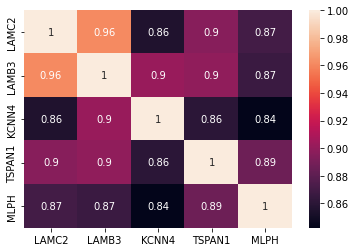

In [ ]:
# Correlació entre les 5 variables
corr_matriu = features.corr()

# Taula de correlacions:
sns.heatmap(corr_matriu, annot=True)

In [ ]:
# Cream el vector de label
labels = dataset.iloc[:,6] # només teixit amb binari
labels = pd.DataFrame(labels, columns=["teixit"])
labels.head(5)

,teixit
0,1
1,0
2,1
3,0
4,1


In [ ]:
# Normalitzem el conjunt features
sc = StandardScaler()
features = sc.fit_transform(features)
features = pd.DataFrame(features, columns=['LAMC2', 'LAMB3', 'KCNN4', 'TSPAN1', 'MLPH'])
features

,LAMC2,LAMB3,KCNN4,TSPAN1,MLPH
0,0.921618,0.855629,0.758203,1.017290,1.747600
1,-1.544348,-1.100435,-0.575723,-1.305169,-0.872507
2,2.117087,2.430965,2.453028,1.259586,1.703982
3,-0.788204,-0.935412,-0.595604,-1.061377,-0.749359
4,1.525297,1.811868,1.994736,1.442919,1.295802
...,...,...,...,...,...
85,-0.709730,-0.817306,-0.708958,-0.490867,-0.496049
86,0.385034,0.015255,0.043903,0.151901,-0.052670
87,-0.727752,-0.947567,-1.274671,-1.315462,-0.873775
88,0.785314,0.918466,0.494729,0.177309,0.638305


In [ ]:
# Train-test split
np.random.seed(2)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=605)

In [ ]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [ ]:
# Shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(67, 5) (23, 5) (67, 1) (23, 1)


ARBRE DE DECISIÓ SIMPLE
------------------

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

arbre = DecisionTreeRegressor(max_depth = 2, random_state = 65)
arbre.fit(X_train, y_train)

# Predim les dades test amb el model
y_pred = arbre.predict(X_test)

y_pred = np.where(y_pred >= 0.5, 1, 0) # Si es major que 1

Profunditat de l'arbre: 2
Nombre de nodes terminals: 4


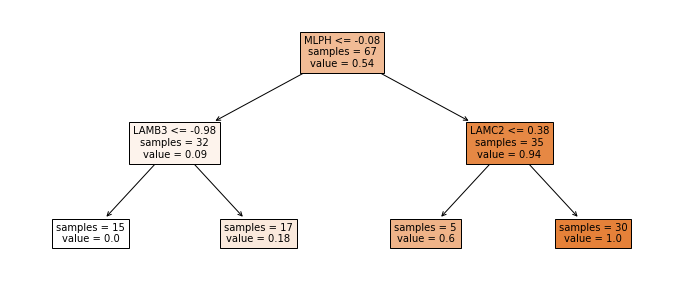

In [ ]:
# Estructura de l'arbre creat

fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profunditat de l'arbre: {arbre.get_depth()}")
print(f"Nombre de nodes terminals: {arbre.get_n_leaves()}")

data = dataset.iloc[:,1:7] # Sense el nom de la mostra

plot = plot_tree(
            decision_tree = arbre,
            feature_names = data.drop(columns = "teixit").columns,
            class_names   = 'teixit',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [ ]:
from sklearn.metrics import accuracy_score

print("Matriu de confusió:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc_tree = accuracy_score(y_test, y_pred)*100
print('Accuracy Decision Tree: {} %'.format(acc_tree))

Matriu de confusió:
[[12  2]
 [ 2  7]]
Accuracy Decision Tree: 82.6086956521739 %


In [ ]:
# Funció per fer la validació encreuada

from sklearn.model_selection import cross_validate

def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Exactitud en l'entrenament": results['train_accuracy'].mean()*100,
              "Sensitivitat en l'entrenament": results['train_recall'].mean()*100,
              "Exactitud en el test": results['test_accuracy'].mean()*100,
              "Sensitivitat en el test": results['test_recall'].mean()*100,}

def plot_result(x_label, y_label, plot_title, train_data, val_data):
      '''Function to plot a grouped bar chart showing the training and validation
        results of the ML model in each fold after applying K-fold cross-validation.
        Parameters
        ----------
        x_label: str, 
          Name of the algorithm used for training e.g 'Decision Tree'
        
        y_label: str, 
          Name of metric being visualized e.g 'Accuracy'
        plot_title: str, 
          This is the title of the plot e.g 'Accuracy Plot'
        
        train_result: list, array
          This is the list containing either training precision, accuracy, or f1 score.
      
        val_result: list, array
          This is the list containing either validation precision, accuracy, or f1 score.
        Returns
        -------
        The function returns a Grouped Barchart showing the training and validation result
        in each fold.
      '''
      
      plt.figure(figsize=(12,6))
      labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
      X_axis = np.arange(len(labels))
      ax = plt.gca()
      plt.ylim(0.40000, 1)
      plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
      plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
      plt.title(plot_title, fontsize=30)
      plt.xticks(X_axis, labels)
      plt.xlabel(x_label, fontsize=14)
      plt.ylabel(y_label, fontsize=14)
      plt.legend()
      plt.grid(True)
      plt.show()

# Referència: https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/

In [ ]:
# LabelEncode del vector label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset2["teixit"])
encoded_labels

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0])

In [ ]:
# Validació encreuada de l'arbre de decisió
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(criterion="entropy", max_depth = 2, random_state=0)
decision_tree_result = cross_validation(decision_tree_model, features, encoded_labels, 5)
print(decision_tree_result)

{"Exactitud en l'entrenament": 90.55555555555556, "Sensitivitat en l'entrenament": 88.33333333333331, 'Exactitud en el test': 85.55555555555556, 'Sensitivitat en el test': 80.0}


In [ ]:
entrenament_arbre = pd.DataFrame(list(decision_tree_result.items()),
                   columns=['Mitjana dels 5 folds de:', '%']).iloc[0:2,:]

test_arbre = pd.DataFrame(list(decision_tree_result.items()),
                   columns=['Mitjana dels 5 folds de:', '%']).iloc[2:4,:]

print(entrenament_arbre)
print("\n")
print(test_arbre)

        Mitjana dels 5 folds de:          %
0     Exactitud en l'entrenament  90.555556
1  Sensitivitat en l'entrenament  88.333333


  Mitjana dels 5 folds de:          %
2     Exactitud en el test  85.555556
3  Sensitivitat en el test  80.000000


RANDOM FOREST
---------------

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=65, n_estimators=21)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [ ]:
from sklearn.metrics import accuracy_score

print("Matriu de confusió:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc_rf = accuracy_score(y_test, y_pred)*100
print('Accuracy Random Forest: {} %'.format(acc_rf))

Matriu de confusió:
[[12  2]
 [ 1  8]]
Accuracy Random Forest: 86.95652173913044 %


In [ ]:
# Validació encreuada del Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=2, random_state=65, n_estimators=21)
rf_result = cross_validation(rf_model, features, encoded_labels, 5)
print(rf_result)

{"Exactitud en l'entrenament": 90.55555555555556, "Sensitivitat en l'entrenament": 89.44444444444444, 'Exactitud en el test': 87.77777777777777, 'Sensitivitat en el test': 86.66666666666666}


In [ ]:
entrenament_rf = pd.DataFrame(list(rf_result.items()),
                   columns=['Mitjana dels 5 folds de:', '%']).iloc[0:2,:]

test_rf = pd.DataFrame(list(rf_result.items()),
                   columns=['Mitjana dels 5 folds de:', '%']).iloc[2:4,:]

print(entrenament_rf)
print("\n")
print(test_rf)

        Mitjana dels 5 folds de:          %
0     Exactitud en l'entrenament  90.555556
1  Sensitivitat en l'entrenament  89.444444


  Mitjana dels 5 folds de:          %
2     Exactitud en el test  87.777778
3  Sensitivitat en el test  86.666667


ANN simple
-------------

In [ ]:
# Cream el model ANN amb els paràmetres obtinguts més avall

# Model amb una sola capa oculta amb 3 neurones
model_ANN_class_base = Sequential([
    Dense(3, activation='relu', input_dim=5),
    #Dense(8, activation='relu'),
    Dense(2, activation="sigmoid")
])

In [ ]:
# Compilam
model_ANN_class_base.compile(loss="sparse_categorical_crossentropy",
              optimizer = Adam(learning_rate=0.01),
              metrics=["accuracy"])

In [ ]:
# Entrenam
history = model_ANN_class_base.fit(X_train, y_train, epochs=15, batch_size = 16, validation_data = (X_test, y_test))

Epoch 1/15
5/5 [==============================] - 1s 46ms/step - loss: 0.8192 - accuracy: 0.4776 - val_loss: 0.8081 - val_accuracy: 0.3913
Epoch 2/15
5/5 [==============================] - 0s 10ms/step - loss: 0.7027 - accuracy: 0.5224 - val_loss: 0.7045 - val_accuracy: 0.4348
Epoch 3/15
5/5 [==============================] - 0s 10ms/step - loss: 0.6123 - accuracy: 0.5672 - val_loss: 0.6251 - val_accuracy: 0.4783
Epoch 4/15
5/5 [==============================] - 0s 14ms/step - loss: 0.5460 - accuracy: 0.7015 - val_loss: 0.5734 - val_accuracy: 0.7391
Epoch 5/15
5/5 [==============================] - 0s 12ms/step - loss: 0.4952 - accuracy: 0.8060 - val_loss: 0.5365 - val_accuracy: 0.8261
Epoch 6/15
5/5 [==============================] - 0s 15ms/step - loss: 0.4586 - accuracy: 0.8955 - val_loss: 0.5141 - val_accuracy: 0.8696
Epoch 7/15
5/5 [==============================] - 0s 12ms/step - loss: 0.4320 - accuracy: 0.8955 - val_loss: 0.4980 - val_accuracy: 0.8696
Epoch 8/15
5/5 [===========

In [ ]:
# Pediccions de les dades test amb el model
y_pred = model_ANN_class_base.predict(X_test)

# Escollim el argmax de cada y_pred
prediccio = list()
for i in range(len(y_pred)):
    prediccio.append(np.argmax(y_pred[i]))

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(prediccio,y_test)
print('Accuracy del model és:', 100*acc)
print('Matriu de confusió:\n',confusion_matrix(y_test,prediccio))

Accuracy del model és: 86.95652173913044
Matriu de confusió:
 [[12  2]
 [ 1  8]]


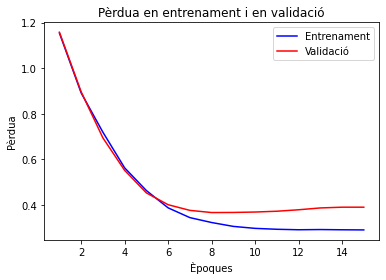

In [ ]:
# Plots de les gràfiques d'accuracy i loss. Corba d'entrenament i de validació
loss = history.history['loss']
val_loss = history.history['val_loss']
epoques = range(1, len(loss) + 1)
plt.plot(epoques, loss, 'b', label='Entrenament')
plt.plot(epoques, val_loss, 'r', label='Validació')
plt.title('Pèrdua en entrenament i en validació')
plt.xlabel('Èpoques')
plt.ylabel('Pèrdua')
plt.legend()
plt.show()

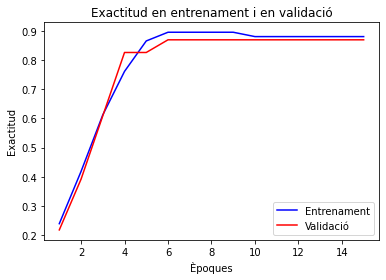

In [ ]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoques = range(1, len(loss) + 1)
plt.plot(epoques, acc, 'b', label='Entrenament')
plt.plot(epoques, val_acc, 'r', label='Validació')
plt.title('Exactitud en entrenament i en validació')
plt.xlabel('Èpoques')
plt.ylabel('Exactitud')
plt.legend()
plt.show()

Millor model ANN
--------------

In [ ]:
# Funció per buscar els millors hiperparàmetres
def model_ANN(batch,epochs,capes,optimizer,lr):

  model = Sequential()

  for i in range(len(capes)): # Per construir la xarxa neuronal
    if i==0:
      model.add(Dense(capes[i], input_dim=5, activation='relu')) # primera capa
    elif i==len(capes):
      model.add(Dense(capes[i], activation='sigmoid')) # darrera capa
    else:
      model.add(Dense(capes[i], activation='relu')) # capes ocultes
      
  
  model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer(learning_rate=lr), metrics=["accuracy"])

  history = model.fit(X_train, y_train, batch_size=batch, epochs=epochs, validation_data = (X_test, y_test), verbose=0)

  return history

In [ ]:
# Cerca de la millor combinació de paràmetres
import math
batch = [16,24,32,38]
epochs = [10,12,15]
capes = [[16, 8, 4], [15, 7], [12, 6], [10, 5], [8, 4], [6, 3], [7], [5], [3]]
optimizers = [Adam, SGD, Adadelta, Adagrad]
lr = [0.1,0.05,0.01]

model = Sequential()
taula = pd.DataFrame(columns=["capes_ocultes", "epoques", "mida_batch", "optimitzador", "lr", "accuracy"])

for b in batch:
  for e in epochs:
    for c in capes:
      for o in optimizers:
        for l in lr:

          model = model_ANN(b,e,c,o,l) # model per cada cominació entre: batch, epochs, capa, optimizer i lr
        
          #Loss amb les dades test (val_loss)
          acc = model.history['accuracy'][e-1] # darrer valor de precisió amb les dades test (depen de les epochs).
          val_acc = model.history['val_accuracy'][e-1]

          fila = pd.DataFrame({"capes_ocultes":[c], "epoques":e, "mida_batch":b, "optimitzador":o, "lr":l,  "accuracy":acc, "val accuracy":val_acc})
          taula = taula.append(fila, ignore_index=True)

taula[taula["val accuracy"]>=0.91]

,capes_ocultes,epoques,mida_batch,optimitzador,lr,accuracy,val accuracy
141,"[12, 6]",12,16,<class 'keras.optimizer_v2.adagrad.Adagrad'>,0.10,0.865672,0.913043
201,[5],12,16,<class 'keras.optimizer_v2.adagrad.Adagrad'>,0.10,0.820895,0.913043
244,"[12, 6]",15,16,<class 'keras.optimizer_v2.gradient_descent.SGD'>,0.05,0.865672,0.956522
276,"[6, 3]",15,16,<class 'keras.optimizer_v2.adam.Adam'>,0.10,0.835821,0.956522
313,[3],15,16,<class 'keras.optimizer_v2.adam.Adam'>,0.05,0.880597,0.913043
443,"[16, 8, 4]",12,24,<class 'keras.optimizer_v2.adagrad.Adagrad'>,0.01,0.850746,0.913043
590,"[8, 4]",15,24,<class 'keras.optimizer_v2.adam.Adam'>,0.01,0.835821,0.913043
591,"[8, 4]",15,24,<class 'keras.optimizer_v2.gradient_descent.SGD'>,0.10,0.805970,0.913043
624,[5],15,24,<class 'keras.optimizer_v2.adam.Adam'>,0.10,0.791045,0.913043
639,[3],15,24,<class 'keras.optimizer_v2.gradient_descent.SGD'>,0.10,0.805970,0.913043


In [ ]:
taula[(taula["val accuracy"]>=0.91) & (taula["accuracy"]>=0.86)]

,capes_ocultes,epoques,mida_batch,optimitzador,lr,accuracy,val accuracy
141,"[12, 6]",12,16,<class 'keras.optimizer_v2.adagrad.Adagrad'>,0.10,0.865672,0.913043
244,"[12, 6]",15,16,<class 'keras.optimizer_v2.gradient_descent.SGD'>,0.05,0.865672,0.956522
313,[3],15,16,<class 'keras.optimizer_v2.adam.Adam'>,0.05,0.880597,0.913043
765,"[16, 8, 4]",12,32,<class 'keras.optimizer_v2.adagrad.Adagrad'>,0.10,0.895522,0.913043


Validació encreuada ANN
------------------


In [ ]:
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def model_ANN():

    model = Sequential([
    Dense(3, activation='relu', input_dim=5),
    #Dense(4, activation='relu'),
    Dense(2, activation="sigmoid")])

    model.compile(loss="sparse_categorical_crossentropy",
              optimizer = Adam(learning_rate=0.1),
              metrics=["accuracy"])
    
    return model

model = model_ANN()

history = model.fit(X_train, y_train, epochs=15, batch_size=16)

keras_clf = KerasClassifier(model_ANN)

ann_result = cross_validation(keras_clf, features, encoded_labels, 5)

ann_result


Epoch 1/15
5/5 [==============================] - 0s 5ms/step - loss: 0.5461 - accuracy: 0.7463
Epoch 2/15
5/5 [==============================] - 0s 5ms/step - loss: 0.4093 - accuracy: 0.8955
Epoch 3/15
5/5 [==============================] - 0s 3ms/step - loss: 0.3321 - accuracy: 0.8955
Epoch 4/15
5/5 [==============================] - 0s 2ms/step - loss: 0.3326 - accuracy: 0.8955
Epoch 5/15
5/5 [==============================] - 0s 3ms/step - loss: 0.3321 - accuracy: 0.9104
Epoch 6/15
5/5 [==============================] - 0s 3ms/step - loss: 0.2962 - accuracy: 0.8955
Epoch 7/15
5/5 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.8955
Epoch 8/15
5/5 [==============================] - 0s 4ms/step - loss: 0.2717 - accuracy: 0.8955
Epoch 9/15
5/5 [==============================] - 0s 3ms/step - loss: 0.3367 - accuracy: 0.9104
Epoch 10/15
5/5 [==============================] - 0s 3ms/step - loss: 0.3554 - accuracy: 0.8955
Epoch 11/15
5/5 [======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


3/3 [==============================] - 0s 5ms/step - loss: 0.5919 - accuracy: 0.5833


{'Exactitud en el test': 88.8888888888889,
 "Exactitud en l'entrenament": 88.61111111111111,
 'Sensitivitat en el test': 88.8888888888889,
 "Sensitivitat en l'entrenament": 88.8888888888889}

In [ ]:
entrenament_ann = pd.DataFrame(list(ann_result.items()),
                   columns=['Mitjana del 5 folds de:', '%']).iloc[0:2,:]

test_ann = pd.DataFrame(list(ann_result.items()),
                   columns=['Mitjana del 5 folds de:', '%']).iloc[2:4,:]

print(entrenament_ann)
print("\n")
print(test_ann)

         Mitjana del 5 folds de:          %
0     Exactitud en l'entrenament  88.611111
1  Sensitivitat en l'entrenament  88.888889


   Mitjana del 5 folds de:          %
2     Exactitud en el test  88.888889
3  Sensitivitat en el test  88.888889


PCA
--------------

In [ ]:
from sklearn.decomposition import PCA

[0.8991046  0.03654321 0.03571376 0.02164862 0.0069898 ]


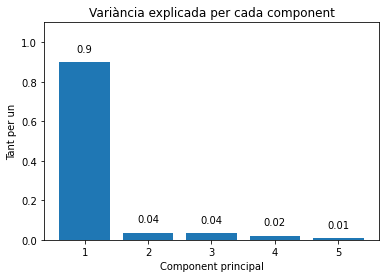

In [ ]:
# Reducció de la dimensionalitat
pca = PCA(n_components=5)
pca.fit_transform(X_train)

# Estudi de la variància explicada.
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(dataset2.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Variància explicada per cada component')
ax.set_xlabel('Component principal')
ax.set_ylabel('Tant per un');

In [ ]:
pca = PCA(n_components=2)
pca2 = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca2.fit_transform(X_test)

X_train_pca_df = pd.DataFrame(data = X_train_pca, columns = ['PC 1', 'PC 2'])
X_test_pca_df = pd.DataFrame(data = X_test_pca, columns = ['PC 1', 'PC 2'])

X_train_pca_df

,PC 1,PC 2
0,-2.025563,-0.358419
1,-2.449665,-0.078247
2,3.898682,0.334301
3,-1.480353,0.024827
4,1.034267,-0.106006
...,...,...
62,1.611790,-0.352750
63,2.954797,-0.710060
64,0.031094,0.153901
65,-2.055979,0.052123


In [ ]:
y_train.index = range(y_train.shape[0])
y_test.index = range(y_test.shape[0])

In [ ]:
X_train_pca_df_teixit = pd.concat([X_train_pca_df, y_train], axis=1)

condicions2 = [(X_train_pca_df_teixit['teixit'] == 1) , (X_train_pca_df_teixit['teixit'] == 0)]
triar2 = ["Tumoral", "Control"]

X_train_pca_df_teixit['teixit'] = np.select(condicions2, triar2, default='Not Specified')

X_train_pca_df_teixit

,PC 1,PC 2,teixit
0,-2.025563,-0.358419,Control
1,-2.449665,-0.078247,Control
2,3.898682,0.334301,Tumoral
3,-1.480353,0.024827,Control
4,1.034267,-0.106006,Tumoral
...,...,...,...
62,1.611790,-0.352750,Tumoral
63,2.954797,-0.710060,Tumoral
64,0.031094,0.153901,Tumoral
65,-2.055979,0.052123,Control


In [ ]:
X_test_pca_df_teixit = pd.concat([X_test_pca_df, y_test], axis=1)

condicions2 = [(X_test_pca_df_teixit['teixit'] == 1) , (X_test_pca_df_teixit['teixit'] == 0)]
triar2 = ["Tumoral", "Control"]

X_test_pca_df_teixit['teixit'] = np.select(condicions2, triar2, default='Not Specified')

X_test_pca_df_teixit

,PC 1,PC 2,teixit
0,1.571762,-0.762133,Tumoral
1,-2.111082,0.040210,Control
2,1.789631,0.077924,Tumoral
3,2.074141,0.681196,Tumoral
4,-1.893955,0.834640,Control
5,-1.414767,0.038116,Control
6,2.662815,0.146120,Tumoral
7,-2.138713,-0.607057,Control
8,-2.436149,-0.184066,Control
9,-0.626604,0.144527,Control


In [ ]:
import plotly.express as px

fig = px.scatter(X_train_pca_df_teixit, x='PC 1', y='PC 2', color=X_train_pca_df_teixit['teixit'])
fig.show()

KNN del PCA
----------

In [ ]:
X_train2 = pd.concat([X_train_pca_df, y_train], axis=1)
X_test2 = pd.concat([X_test_pca_df, y_test], axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics

acc_dic = {}

for i in range(1,10):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train2, y_train)
  y_pred = knn.predict(X_test2)
  acc = metrics.accuracy_score(y_test, y_pred)
  acc_dic[i] = acc

{1: 0.9565217391304348, 2: 0.9565217391304348, 3: 0.9565217391304348, 4: 0.9565217391304348, 5: 0.9130434782608695, 6: 0.8695652173913043, 7: 0.8695652173913043, 8: 0.8695652173913043, 9: 0.8695652173913043}


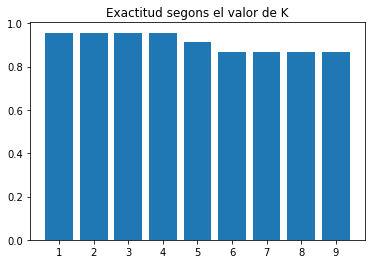

In [ ]:
names = list(acc_dic.keys())
values = list(acc_dic.values())

print(acc_dic)

plt.bar(range(len(acc_dic)), values, tick_label=names)
plt.title("Exactitud segons el valor de K")
plt.show()

In [ ]:
# KNN

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train2, y_train)
y_pred = knn.predict(X_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [ ]:
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))

[[13  1]
 [ 0  9]]
Accuracy: 0.9565217391304348


Validació encreuada K-NN
------------------

In [ ]:
pca3 = PCA(n_components=2)
features_pca = pca3.fit_transform(features)

{1: 83.33333333333333, 2: 81.11111111111111, 3: 85.55555555555556, 4: 83.33333333333334, 5: 87.77777777777777, 6: 86.66666666666666, 7: 87.77777777777777, 8: 86.66666666666666, 9: 88.8888888888889, 10: 88.8888888888889, 11: 88.8888888888889, 12: 87.77777777777779, 13: 88.8888888888889, 14: 87.77777777777779, 15: 88.8888888888889, 16: 86.66666666666666, 17: 87.77777777777777, 18: 86.66666666666666, 19: 87.77777777777777}
{1: 84.44444444444444, 2: 71.1111111111111, 3: 84.44444444444444, 4: 77.77777777777779, 5: 86.66666666666666, 6: 84.44444444444444, 7: 86.66666666666666, 8: 84.44444444444444, 9: 88.8888888888889, 10: 88.8888888888889, 11: 88.8888888888889, 12: 86.66666666666666, 13: 88.8888888888889, 14: 86.66666666666666, 15: 88.8888888888889, 16: 84.44444444444444, 17: 86.66666666666666, 18: 84.44444444444444, 19: 86.66666666666666}


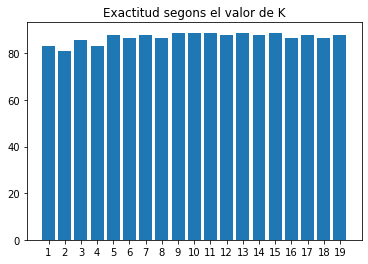

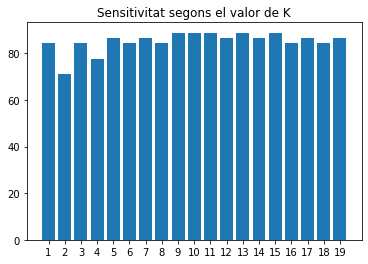

In [ ]:
acc_dic = {}
sen_dic = {}

for i in range(1,20):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn_result = cross_validation(knn, features_pca, encoded_labels, 5)
  acc_dic[i] = knn_result["Exactitud en el test"]
  sen_dic[i] = knn_result["Sensitivitat en el test"]

names = list(acc_dic.keys())
values1 = list(acc_dic.values())
values2 = list(sen_dic.values())

print(acc_dic)
print(sen_dic)

plt.bar(range(len(acc_dic)), values1, tick_label=names)
plt.title("Exactitud segons el valor de K")
plt.show()

plt.bar(range(len(acc_dic)), values2, tick_label=names)
plt.title("Sensitivitat segons el valor de K")
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9)

pca3 = PCA(n_components=2)
features_pca = pca3.fit_transform(features)

knn_result = cross_validation(knn, features_pca, encoded_labels, 5)

knn_result

{'Exactitud en el test': 88.8888888888889,
 "Exactitud en l'entrenament": 87.5,
 'Sensitivitat en el test': 88.8888888888889,
 "Sensitivitat en l'entrenament": 86.1111111111111}

In [ ]:
entrenament_knn = pd.DataFrame(list(knn_result.items()),
                   columns=['Mitjana del 5 folds de:', '%']).iloc[0:2,:]

test_knn = pd.DataFrame(list(knn_result.items()),
                   columns=['Mitjana del 5 folds de:', '%']).iloc[2:4,:]

print(entrenament_knn)
print("\n")
print(test_knn)

         Mitjana del 5 folds de:          %
0     Exactitud en l'entrenament  87.500000
1  Sensitivitat en l'entrenament  86.111111


   Mitjana del 5 folds de:          %
2     Exactitud en el test  88.888889
3  Sensitivitat en el test  88.888889
